# Neuroblastoma Gene Signature Survival Analysis

## Getting Started

In [2]:
# Code cell to be removed in the final version
from IPython.display import Javascript

keep_alive = Javascript('''
    function KeepAlive(){
        console.log("Keeping notebook alive");
        setInterval(function(){
            var xhr = new XMLHttpRequest();
            xhr.open("GET", "/", true);
            xhr.send();
        }, 60000);  // 60 seconds interval
    }
    KeepAlive();
''')

display(keep_alive)

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

## Gene Expression Data

In [4]:
# Load gene expression data
gene_expression_file = "dataset/GSE49711_SEQC_NB_TAV_G_log2.final.txt"
gene_data = pd.read_csv(gene_expression_file, sep='\t')

In [5]:
# veiw data
gene_data.head(200)

,Gene,Gene_set,NCBI_gene_ID,RefSeq_transcript_ID,Chromosome,Strand,Start,End,SEQC_NB001,SEQC_NB002,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,2-oxoacid_dh,Gene_AceView,.,.,11,-,111933358,111934981,16.1928,16.5853,...,16.8862,17.7853,16.3760,16.9434,17.3701,17.8362,17.8373,17.4535,17.3726,16.8897
1,A1BGAS,Gene_AceView,503538,NR_015380.1,19,+,58859074,58866555,17.2744,15.3742,...,16.8690,16.7470,15.6558,16.7318,16.6318,16.4946,16.8059,16.2498,17.6346,16.8966
2,A1CF,Gene_AceView,29974,NM_001198818.1;NM_001198819.1;NM_001198820.1;N...,10,-,52566307,52645436,8.7985,0.0000,...,0.0000,10.8696,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.4219,0.0000
3,A2BP1,Gene_AceView,54715,NM_001142333.1;NM_001142334.1;NM_018723.3;NM_1...,16,+,6068990,7763341,16.8905,18.6162,...,14.9643,16.0162,15.5955,15.4929,17.4806,20.0256,19.4085,19.4109,20.0640,19.3468
4,A2LD1,Gene_AceView,87769,NM_001195087.1;NM_033110.2,13,-,101182342,101241782,13.8812,14.0487,...,13.9839,16.1991,14.4934,15.0323,15.1812,14.7423,14.6655,13.7998,15.1968,14.5997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ACSS2,Gene_AceView,55902,NM_001076552.2;NM_001242393.1;NM_018677.3;NM_1...,20,+,33460250,33515775,18.1079,18.6159,...,17.8572,17.7807,18.1700,18.0642,18.3047,17.9795,18.4696,18.2811,18.0744,18.3548
196,ACSS3,Gene_AceView,79611,NM_024560.2,12,+,81331595,81650746,13.8122,13.4059,...,12.2479,14.2277,12.9950,13.7934,14.3377,14.5500,14.9275,14.9621,15.0501,15.2317
197,ACTA1,Gene_AceView,58,NM_001100.3,1,-,229566986,229569840,13.2074,13.5339,...,12.3445,11.3854,11.5715,11.2827,13.3193,11.5634,12.8683,12.0049,13.4456,12.4486
198,ACTA2,Gene_AceView,59,NM_001141945.1;NM_001613.2,10,-,90694826,90751572,20.6453,19.3269,...,19.7273,22.8411,18.3877,20.7247,20.1034,21.7489,20.5502,22.1927,20.8221,21.0784


## Metadata

In [6]:
# Read and print the first few lines of the file
with open("dataset/GSE49711_series_matrix.txt", 'r') as file:
    for _ in range(66):
        print(file.readline())

!Series_title	"RNA-Seq reveals an unprecedented complexity of the neuroblastoma transcriptome and is suitable for clinical endpoint prediction [RNA-Seq]"

!Series_geo_accession	"GSE49711"

!Series_status	"Public on May 22 2015"

!Series_submission_date	"Aug 09 2013"

!Series_last_update_date	"Feb 08 2017"

!Series_pubmed_id	"25150839"

!Series_pubmed_id	"25150838"

!Series_pubmed_id	"25254650"

!Series_summary	"We generated gene expression profiles from 498 primary neuroblastomas using RNA-Seq and microarrays. We sought to systematically evaluate the capability of RNA deep-sequencing (RNA-Seq)-based classification for clinical endpoint prediction in comparison to microarray-based ones. The neuroblastoma cohort was randomly divided into training and validation sets, and 360 predictive models on six clinical endpoints were generated and evaluated. While prediction performances did not differ considerably between the two technical platforms, the RNA-Seq data processing pipelines, or featu

In [7]:
# Read metadata with more controlled handling
metadata_file = "dataset/GSE49711_series_matrix.txt"

# Adjusted this value based on where the data starts as showen above
skip_lines = 66

# Read the file, skipping initial lines and ensuring correct delimiter
metadata = pd.read_csv(metadata_file, sep='\t', skiprows=skip_lines)

# Display first few rows of metadata
metadata.head(50)

,!Sample_title,SEQC_NB001,SEQC_NB002,SEQC_NB003,SEQC_NB004,SEQC_NB005,SEQC_NB006,SEQC_NB007,SEQC_NB008,SEQC_NB009,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,!Sample_geo_accession,GSM1205736,GSM1205737,GSM1205738,GSM1205739,GSM1205740,GSM1205741,GSM1205742,GSM1205743,GSM1205744,...,GSM1206224,GSM1206225,GSM1206226,GSM1206227,GSM1206228,GSM1206229,GSM1206230,GSM1206231,GSM1206232,GSM1206233
1,!Sample_status,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,...,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015
2,!Sample_submission_date,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,...,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013
3,!Sample_last_update_date,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,...,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,...,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,...,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma
9,!Sample_characteristics_ch1,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,...,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2


In [8]:
# Read and print the first few lines of the file
with open("dataset/GSE62564_series_matrix.txt", 'r') as file:
    for _ in range(50):
        print(file.readline())

!Series_title	"An Investigation of Biomarkers Derived from Legacy Microarray Data for Their Utility in the RNA-Seq Era"

!Series_geo_accession	"GSE62564"

!Series_status	"Public on Oct 22 2014"

!Series_submission_date	"Oct 21 2014"

!Series_last_update_date	"Mar 27 2019"

!Series_pubmed_id	"25150839"

!Series_pubmed_id	"25150838"

!Series_pubmed_id	"25254650"

!Series_pubmed_id	"25633159"

!Series_summary	"Gene expression microarray has been the primary biomarker platform ubiquitously applied in biomedical research, resulting in enormous data, predictive models and biomarkers accrued. Recently, RNA-seq has looked likely to replace microarrays, but there will be a period where both technologies coexist. This raises two important questions: can microarray-based models and biomarkers be directly applied to RNA-Seq data? Can future RNA-Seq-based predictive models and biomarkers be applied to microarray data to leverage past investment? We systematically evaluated the transferability of pr

In [9]:
# Read metadata with more controlled handling
metadata_file = "dataset/GSE62564_series_matrix.txt"

# Adjusted this value based on where the data starts as showen above
skip_lines = 50

# Read the file, skipping initial lines and ensuring correct delimiter
metadata = pd.read_csv(metadata_file, sep='\t', skiprows=skip_lines)

# Display first few rows of metadata
metadata.head(100)

,!Sample_title,SEQC_NB001 [2],SEQC_NB002 [2],SEQC_NB003 [2],SEQC_NB004 [2],SEQC_NB005 [2],SEQC_NB006 [2],SEQC_NB007 [2],SEQC_NB008 [2],SEQC_NB009 [2],...,SEQC_NB489 [2],SEQC_NB490 [2],SEQC_NB491 [2],SEQC_NB492 [2],SEQC_NB493 [2],SEQC_NB494 [2],SEQC_NB495 [2],SEQC_NB496 [2],SEQC_NB497 [2],SEQC_NB498 [2]
0,!Sample_geo_accession,GSM1528894,GSM1528895,GSM1528896,GSM1528897,GSM1528898,GSM1528899,GSM1528900,GSM1528901,GSM1528902,...,GSM1529384,GSM1529385,GSM1529386,GSM1529387,GSM1529388,GSM1529389,GSM1529390,GSM1529391,GSM1529392,GSM1529393
1,!Sample_status,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,...,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014
2,!Sample_submission_date,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,...,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014
3,!Sample_last_update_date,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,...,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,...,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,...,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation
9,!Sample_characteristics_ch1,Sex: M,Sex: M,Sex: F,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: F,...,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: F,Sex: F


In [10]:
# Remove " [2]" from sample titles
metadata.columns = metadata.columns.str.replace(' \[2\]', '', regex=True)


In [11]:
# Display the first few rows to verify
metadata.head(100)

,!Sample_title,SEQC_NB001,SEQC_NB002,SEQC_NB003,SEQC_NB004,SEQC_NB005,SEQC_NB006,SEQC_NB007,SEQC_NB008,SEQC_NB009,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,!Sample_geo_accession,GSM1528894,GSM1528895,GSM1528896,GSM1528897,GSM1528898,GSM1528899,GSM1528900,GSM1528901,GSM1528902,...,GSM1529384,GSM1529385,GSM1529386,GSM1529387,GSM1529388,GSM1529389,GSM1529390,GSM1529391,GSM1529392,GSM1529393
1,!Sample_status,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,...,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014
2,!Sample_submission_date,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,...,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014
3,!Sample_last_update_date,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,...,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,...,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,...,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation
9,!Sample_characteristics_ch1,Sex: M,Sex: M,Sex: F,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: F,...,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: F,Sex: F


# Calculating Gene Signature Scores

### Prepare Data

In [12]:
# Extract 'os day' and 'os bin' rows and transpose the DataFrame for easier manipulation
os_day_row = metadata.iloc[13, 1:].str.split(': ').str[1].astype(int)  # Splitting and converting to integer
os_bin_row = metadata.iloc[14, 1:].str.split(': ').str[1].astype(int)

# Creating new DataFrame
data = pd.DataFrame({
    'Sample ID': metadata.columns[1:],  # Extracting Sample IDs from the column headers, skipping the first entry
    'os days': os_day_row.values,
    'os bin': os_bin_row.values
})

In [13]:
data

,Sample ID,os days,os bin
0,SEQC_NB001,1362,1
1,SEQC_NB002,2836,1
2,SEQC_NB003,1191,1
3,SEQC_NB004,2046,0
4,SEQC_NB005,220,1
...,...,...,...
493,SEQC_NB494,4828,0
494,SEQC_NB495,2467,0
495,SEQC_NB496,5780,0
496,SEQC_NB497,4883,0


### TGF Beta

In [14]:
# Read the gene list from the file
with open("dataset/HALLMARK_TGF_BETA_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
tgfb_gene_list = gene_list[2:]

# Print the gene list to verify
print(tgfb_gene_list)

['ACVR1', 'APC', 'ARID4B', 'BCAR3', 'BMP2', 'BMPR1A', 'BMPR2', 'CDH1', 'CDK9', 'CDKN1C', 'CTNNB1', 'ENG', 'FKBP1A', 'FNTA', 'FURIN', 'HDAC1', 'HIPK2', 'ID1', 'ID2', 'ID3', 'IFNGR2', 'JUNB', 'KLF10', 'LEFTY2', 'LTBP2', 'MAP3K7', 'NCOR2', 'NOG', 'PMEPA1', 'PPM1A', 'PPP1CA', 'PPP1R15A', 'RAB31', 'RHOA', 'SERPINE1', 'SKI', 'SKIL', 'SLC20A1', 'SMAD1', 'SMAD3', 'SMAD6', 'SMAD7', 'SMURF1', 'SMURF2', 'SPTBN1', 'TGFB1', 'TGFBR1', 'TGIF1', 'THBS1', 'TJP1', 'TRIM33', 'UBE2D3', 'WWTR1', 'XIAP']


In [15]:
# List of Tgfb pathway genes
tgfb_genes = tgfb_gene_list

# Calculate Tgfb signature scores for each sample
tgfb_scores = gene_data[gene_data['Gene'].isin(tgfb_genes)].iloc[:, 8:].mean(axis=0)
tgfb_scores.name = 'tgfb_score'

# Combine tgfb scores with metadata
data['tgfb_score'] = data['Sample ID'].map(tgfb_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['tgfb_score'], inplace=True)

In [16]:
tgfb_scores.head()

SEQC_NB001    18.269337
SEQC_NB002    17.887488
SEQC_NB003    17.871847
SEQC_NB004    18.281798
SEQC_NB005    18.154788
Name: tgfb_score, dtype: float64

### IL2 STAT5

In [17]:
# Read the gene list from the file
with open("dataset/HALLMARK_IL2_STAT5_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
il2_stat5_gene_list = gene_list[2:]

# Print the gene list to verify
print(il2_stat5_gene_list)

['ABCB1', 'ADAM19', 'AGER', 'AHCY', 'AHNAK', 'AHR', 'ALCAM', 'AMACR', 'ANXA4', 'APLP1', 'ARL4A', 'BATF', 'BATF3', 'BCL2', 'BCL2L1', 'BHLHE40', 'BMP2', 'BMPR2', 'CA2', 'CAPG', 'CAPN3', 'CASP3', 'CCND2', 'CCND3', 'CCNE1', 'CCR4', 'CD44', 'CD48', 'CD79B', 'CD81', 'CD83', 'CD86', 'CDC42SE2', 'CDC6', 'CDCP1', 'CDKN1C', 'CISH', 'CKAP4', 'COCH', 'COL6A1', 'CSF1', 'CSF2', 'CST7', 'CTLA4', 'CTSZ', 'CXCL10', 'CYFIP1', 'DCPS', 'DENND5A', 'DHRS3', 'DRC1', 'ECM1', 'EEF1AKMT1', 'EMP1', 'ENO3', 'ENPP1', 'EOMES', 'ETFBKMT', 'ETV4', 'F2RL2', 'FAH', 'FGL2', 'FLT3LG', 'FURIN', 'GABARAPL1', 'GADD45B', 'GALM', 'GATA1', 'GBP4', 'GLIPR2', 'GPR65', 'GPR83', 'GPX4', 'GSTO1', 'GUCY1B1', 'HIPK2', 'HK2', 'HOPX', 'HUWE1', 'HYCC2', 'ICOS', 'IFITM3', 'IFNGR1', 'IGF1R', 'IGF2R', 'IKZF2', 'IKZF4', 'IL10', 'IL10RA', 'IL13', 'IL18R1', 'IL1R2', 'IL1RL1', 'IL2RA', 'IL2RB', 'IL3RA', 'IL4R', 'IRF4', 'IRF6', 'IRF8', 'ITGA6', 'ITGAE', 'ITGAV', 'ITIH5', 'KLF6', 'LCLAT1', 'LIF', 'LRIG1', 'LRRC8C', 'LTB', 'MAFF', 'MAP3K8', 'MAP6

In [18]:
# List of il2 stat5 signaling pathway genes
il2_stat5_genes = il2_stat5_gene_list

# Calculate Tgfb signature scores for each sample
il2_stat5_scores = gene_data[gene_data['Gene'].isin(il2_stat5_genes)].iloc[:, 8:].mean(axis=0)
il2_stat5_scores.name = 'il2_stat5_score'

# Combine il2 scores with metadata
data['il2_stat5_score'] = data['Sample ID'].map(il2_stat5_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['il2_stat5_score'], inplace=True)

In [19]:
il2_stat5_scores.head()

SEQC_NB001    17.244859
SEQC_NB002    16.696371
SEQC_NB003    16.120460
SEQC_NB004    17.053701
SEQC_NB005    16.878057
Name: il2_stat5_score, dtype: float64

### IL6 JAK STAT3

In [20]:
# Read the gene list from the file
with open("dataset/HALLMARK_IL6_JAK_STAT3_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
il6_jak_stat3_gene_list = gene_list[2:]

# Print the gene list to verify
print(il6_jak_stat3_gene_list)

['A2M', 'ACVR1B', 'ACVRL1', 'BAK1', 'CBL', 'CCL7', 'CCR1', 'CD14', 'CD36', 'CD38', 'CD44', 'CD9', 'CNTFR', 'CRLF2', 'CSF1', 'CSF2', 'CSF2RA', 'CSF2RB', 'CSF3R', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL13', 'CXCL3', 'CXCL9', 'DNTT', 'EBI3', 'FAS', 'GRB2', 'HAX1', 'HMOX1', 'IFNAR1', 'IFNGR1', 'IFNGR2', 'IL10RB', 'IL12RB1', 'IL13RA1', 'IL15RA', 'IL17RA', 'IL17RB', 'IL18R1', 'IL1B', 'IL1R1', 'IL1R2', 'IL2RA', 'IL2RG', 'IL3RA', 'IL4R', 'IL6', 'IL6ST', 'IL7', 'IL9R', 'INHBE', 'IRF1', 'IRF9', 'ITGA4', 'ITGB3', 'JUN', 'LEPR', 'LTB', 'LTBR', 'MAP3K8', 'MYD88', 'OSMR', 'PDGFC', 'PF4', 'PIK3R5', 'PIM1', 'PLA2G2A', 'PTPN1', 'PTPN11', 'PTPN2', 'REG1A', 'SOCS1', 'SOCS3', 'STAM2', 'STAT1', 'STAT2', 'STAT3', 'TGFB1', 'TLR2', 'TNF', 'TNFRSF12A', 'TNFRSF1A', 'TNFRSF1B', 'TNFRSF21', 'TYK2']


In [21]:
# List of il6 jak stat3 signaling pathway genes
il6_jak_stat3_genes = il6_jak_stat3_gene_list

# Calculate Tgfb signature scores for each sample
il6_jak_stat3_scores = gene_data[gene_data['Gene'].isin(il6_jak_stat3_genes)].iloc[:, 8:].mean(axis=0)
il6_jak_stat3_scores.name = 'il6_jak_stat3_score'

# Combine tgfb scores with metadata
data['il6_jak_stat3_score'] = data['Sample ID'].map(il6_jak_stat3_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['il6_jak_stat3_score'], inplace=True)

In [22]:
il6_jak_stat3_scores.head()

SEQC_NB001    16.482722
SEQC_NB002    15.697078
SEQC_NB003    14.869950
SEQC_NB004    15.792001
SEQC_NB005    15.197942
Name: il6_jak_stat3_score, dtype: float64

### Inflammatory Response

In [23]:
# Read the gene list from the file
with open("dataset/HALLMARK_INFLAMMATORY_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
inflammatory_gene_list = gene_list[2:]

# Print the gene list to verify
print(inflammatory_gene_list)

['ABCA1', 'ABI1', 'ACVR1B', 'ACVR2A', 'ADGRE1', 'ADM', 'ADORA2B', 'ADRM1', 'AHR', 'APLNR', 'AQP9', 'ATP2A2', 'ATP2B1', 'ATP2C1', 'AXL', 'BDKRB1', 'BEST1', 'BST2', 'BTG2', 'C3AR1', 'C5AR1', 'CALCRL', 'CCL17', 'CCL2', 'CCL20', 'CCL22', 'CCL24', 'CCL5', 'CCL7', 'CCR7', 'CCRL2', 'CD14', 'CD40', 'CD48', 'CD55', 'CD69', 'CD70', 'CD82', 'CDKN1A', 'CHST2', 'CLEC5A', 'CMKLR1', 'CSF1', 'CSF3', 'CSF3R', 'CX3CL1', 'CXCL10', 'CXCL11', 'CXCL6', 'CXCL8', 'CXCL9', 'CXCR6', 'CYBB', 'DCBLD2', 'EBI3', 'EDN1', 'EIF2AK2', 'EMP3', 'EREG', 'F3', 'FFAR2', 'FPR1', 'FZD5', 'GABBR1', 'GCH1', 'GNA15', 'GNAI3', 'GP1BA', 'GPC3', 'GPR132', 'GPR183', 'HAS2', 'HBEGF', 'HIF1A', 'HPN', 'HRH1', 'ICAM1', 'ICAM4', 'ICOSLG', 'IFITM1', 'IFNAR1', 'IFNGR2', 'IL10', 'IL10RA', 'IL12B', 'IL15', 'IL15RA', 'IL18', 'IL18R1', 'IL18RAP', 'IL1A', 'IL1B', 'IL1R1', 'IL2RB', 'IL4R', 'IL6', 'IL7R', 'INHBA', 'IRAK2', 'IRF1', 'IRF7', 'ITGA5', 'ITGB3', 'ITGB8', 'KCNA3', 'KCNJ2', 'KCNMB2', 'KIF1B', 'KLF6', 'LAMP3', 'LCK', 'LCP2', 'LDLR', 'LIF'

In [24]:
# List of inflamatory response pathway genes
inflammatory_genes = inflammatory_gene_list

# Calculate Tgfb signature scores for each sample
inflammatory_scores = gene_data[gene_data['Gene'].isin(inflammatory_genes)].iloc[:, 8:].mean(axis=0)
inflammatory_scores.name = 'inflammatory_score'

# Combine tgfb scores with metadata
data['inflammatory_score'] = data['Sample ID'].map(inflammatory_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['inflammatory_score'], inplace=True)

In [25]:
inflammatory_scores.head()

SEQC_NB001    15.634172
SEQC_NB002    15.270535
SEQC_NB003    14.382875
SEQC_NB004    15.186789
SEQC_NB005    15.045142
Name: inflammatory_score, dtype: float64

### Interferon Alpha

In [26]:
# Read the gene list from the file
with open("dataset/HALLMARK_INTERFERON_ALPHA_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
ifna_gene_list = gene_list[2:]

# Print the gene list to verify
print(ifna_gene_list)

['ADAR', 'B2M', 'BATF2', 'BST2', 'C1S', 'CASP1', 'CASP8', 'CCRL2', 'CD47', 'CD74', 'CMPK2', 'CMTR1', 'CNP', 'CSF1', 'CXCL10', 'CXCL11', 'DDX60', 'DHX58', 'EIF2AK2', 'ELF1', 'EPSTI1', 'GBP2', 'GBP4', 'GMPR', 'HELZ2', 'HERC6', 'HLA-C', 'IFI27', 'IFI30', 'IFI35', 'IFI44', 'IFI44L', 'IFIH1', 'IFIT2', 'IFIT3', 'IFITM1', 'IFITM2', 'IFITM3', 'IL15', 'IL4R', 'IL7', 'IRF1', 'IRF2', 'IRF7', 'IRF9', 'ISG15', 'ISG20', 'LAMP3', 'LAP3', 'LGALS3BP', 'LPAR6', 'LY6E', 'MOV10', 'MVB12A', 'MX1', 'NCOA7', 'NMI', 'NUB1', 'OAS1', 'OASL', 'OGFR', 'PARP12', 'PARP14', 'PARP9', 'PLSCR1', 'PNPT1', 'PROCR', 'PSMA3', 'PSMB8', 'PSMB9', 'PSME1', 'PSME2', 'RIPK2', 'RNF31', 'RSAD2', 'RTP4', 'SAMD9', 'SAMD9L', 'SELL', 'SLC25A28', 'SP110', 'STAT2', 'TAP1', 'TDRD7', 'TENT5A', 'TMEM140', 'TRAFD1', 'TRIM14', 'TRIM21', 'TRIM25', 'TRIM26', 'TRIM5', 'TXNIP', 'UBA7', 'UBE2L6', 'USP18', 'WARS1']


In [27]:
# List of ifng response pathway genes
ifna_genes = ifna_gene_list

# Calculate Tgfb signature scores for each sample
ifna_scores = gene_data[gene_data['Gene'].isin(ifna_genes)].iloc[:, 8:].mean(axis=0)
ifna_scores.name = 'ifna_score'

# Combine tgfb scores with metadata
data['ifna_score'] = data['Sample ID'].map(ifna_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['ifna_score'], inplace=True)

In [28]:
ifna_scores.head()

SEQC_NB001    18.813415
SEQC_NB002    17.277249
SEQC_NB003    16.387085
SEQC_NB004    17.403907
SEQC_NB005    17.422367
Name: ifna_score, dtype: float64

### Interferon Gamma

In [29]:
# Read the gene list from the file
with open("dataset/HALLMARK_INTERFERON_GAMMA_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
ifng_gene_list = gene_list[2:]

# Print the gene list to verify
print(ifng_gene_list)

['ADAR', 'APOL6', 'ARID5B', 'ARL4A', 'AUTS2', 'B2M', 'BANK1', 'BATF2', 'BPGM', 'BST2', 'BTG1', 'C1R', 'C1S', 'CASP1', 'CASP3', 'CASP4', 'CASP7', 'CASP8', 'CCL2', 'CCL5', 'CCL7', 'CD274', 'CD38', 'CD40', 'CD69', 'CD74', 'CD86', 'CDKN1A', 'CFB', 'CFH', 'CIITA', 'CMKLR1', 'CMPK2', 'CMTR1', 'CSF2RB', 'CXCL10', 'CXCL11', 'CXCL9', 'DDX60', 'DHX58', 'EIF2AK2', 'EIF4E3', 'EPSTI1', 'FAS', 'FCGR1A', 'FGL2', 'FPR1', 'GBP4', 'GBP6', 'GCH1', 'GPR18', 'GZMA', 'HELZ2', 'HERC6', 'HIF1A', 'HLA-A', 'HLA-B', 'HLA-DMA', 'HLA-DQA1', 'HLA-DRB1', 'HLA-G', 'ICAM1', 'IDO1', 'IFI27', 'IFI30', 'IFI35', 'IFI44', 'IFI44L', 'IFIH1', 'IFIT1', 'IFIT2', 'IFIT3', 'IFITM2', 'IFITM3', 'IFNAR2', 'IL10RA', 'IL15', 'IL15RA', 'IL18BP', 'IL2RB', 'IL4R', 'IL6', 'IL7', 'IRF1', 'IRF2', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'ISOC1', 'ITGB7', 'JAK2', 'KLRK1', 'LAP3', 'LATS2', 'LCP2', 'LGALS3BP', 'LY6E', 'LYSMD2', 'MARCHF1', 'METTL7B', 'MT2A', 'MTHFD2', 'MVP', 'MX1', 'MX2', 'MYD88', 'NAMPT', 'NCOA3', 'NFKB1', 'N

In [30]:
# List of ifng response pathway genes
ifng_genes = ifng_gene_list

# Calculate Tgfb signature scores for each sample
ifng_scores = gene_data[gene_data['Gene'].isin(ifng_genes)].iloc[:, 8:].mean(axis=0)
ifng_scores.name = 'ifng_score'

# Combine tgfb scores with metadata
data['ifng_score'] = data['Sample ID'].map(ifng_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['ifng_score'], inplace=True)

In [31]:
ifng_scores.head()

SEQC_NB001    18.199822
SEQC_NB002    17.047478
SEQC_NB003    16.125509
SEQC_NB004    17.065319
SEQC_NB005    16.811052
Name: ifng_score, dtype: float64

### Final Data

In [32]:
# Display the data to verify
data.head(100)

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052
...,...,...,...,...,...,...,...,...,...
95,SEQC_NB096,3977,0,18.028390,16.771964,15.684321,15.271098,17.187849,16.908194
96,SEQC_NB097,3641,0,18.449957,17.387568,16.648688,15.945750,17.541887,17.449249
97,SEQC_NB098,4042,0,17.734043,16.430237,14.934844,14.424689,16.293699,16.074294
98,SEQC_NB099,2167,0,18.278833,17.052905,16.150145,15.524826,16.976634,16.748258


## Quantile Survival Analysis
- **Kaplan-Meier Plot**: The Kaplan-Meier plot will show the survival probability over time for the top 25% and bottom 25% of Tgfb scores.
- **Log-Rank Test**: Perform a log-rank test to determine if the difference in survival between the two groups is statistically significant.

### TGF Beta

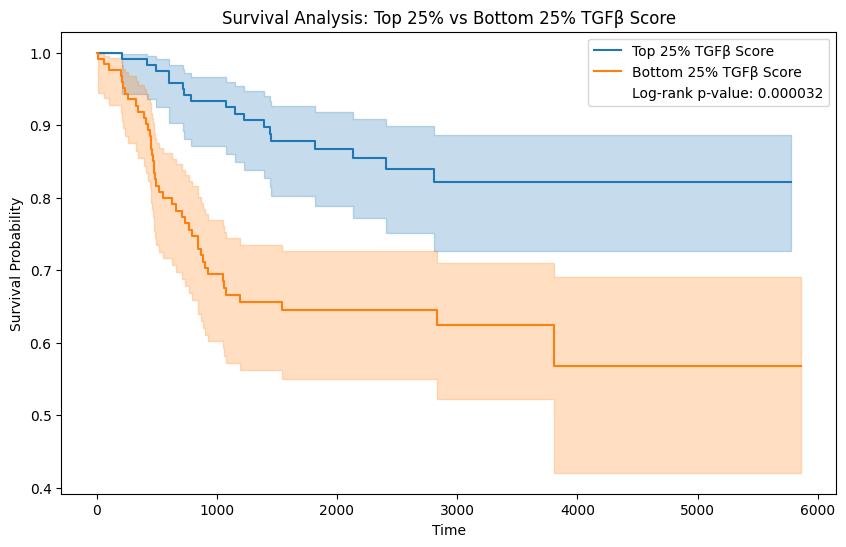

In [33]:
# Stratify samples into top 25% and bottom 25% based on tgfb_score
top_25 = data[data['tgfb_score'] >= data['tgfb_score'].quantile(0.75)]
bottom_25 = data[data['tgfb_score'] <= data['tgfb_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFβ score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TGFβ Score')
ax = kmf.plot_survival_function()

# Bottom 25% TGFβ score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TGFβ Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TGFβ Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TGFβ Score', f'Bottom 25% TGFβ Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

### IL2 STAT5

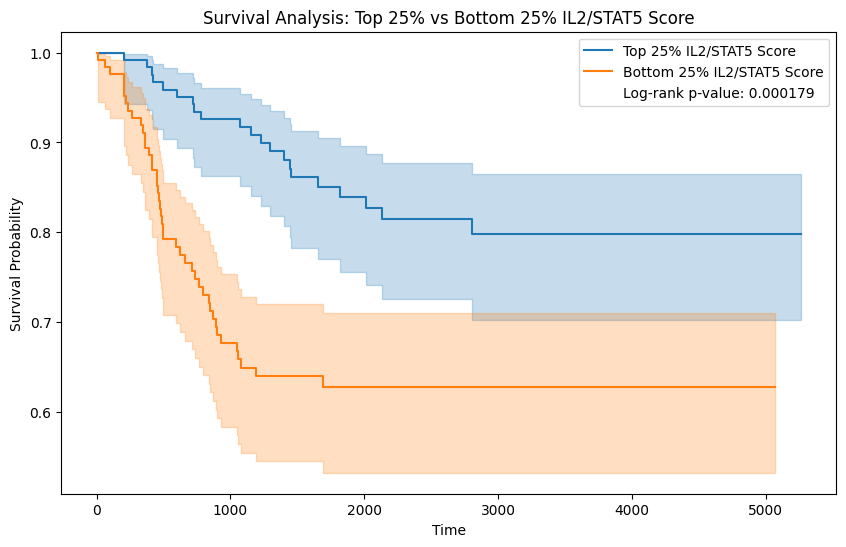

In [34]:
# Stratify samples into top 25% and bottom 25% based on il2_stat5_score
top_25 = data[data['il2_stat5_score'] >= data['il2_stat5_score'].quantile(0.75)]
bottom_25 = data[data['il2_stat5_score'] <= data['il2_stat5_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IL2/STAT5 score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IL2/STAT5 Score')
ax = kmf.plot_survival_function()

# Bottom 25% IL2/STAT5 score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IL2/STAT5 Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IL2/STAT5 Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IL2/STAT5 Score', f'Bottom 25% IL2/STAT5 Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

### IL6 JAK STAT3

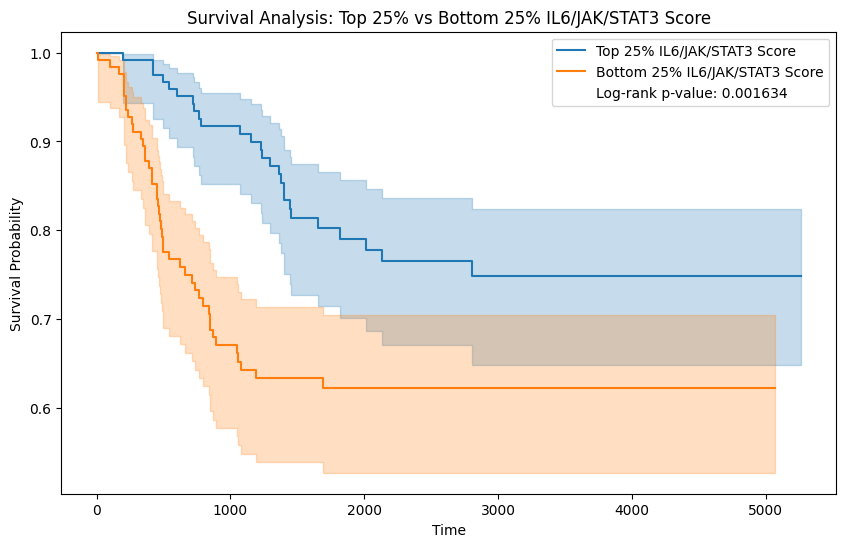

In [35]:
# Stratify samples into top 25% and bottom 25% based on il6_jak_stat3_score
top_25 = data[data['il6_jak_stat3_score'] >= data['il6_jak_stat3_score'].quantile(0.75)]
bottom_25 = data[data['il6_jak_stat3_score'] <= data['il6_jak_stat3_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IL6/JAK/STAT3 score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IL6/JAK/STAT3 Score')
ax = kmf.plot_survival_function()

# Bottom 25% IL6/JAK/STAT3 score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IL6/JAK/STAT3 Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IL6/JAK/STAT3 Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IL6/JAK/STAT3 Score', f'Bottom 25% IL6/JAK/STAT3 Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

### Inflamatory Pathway

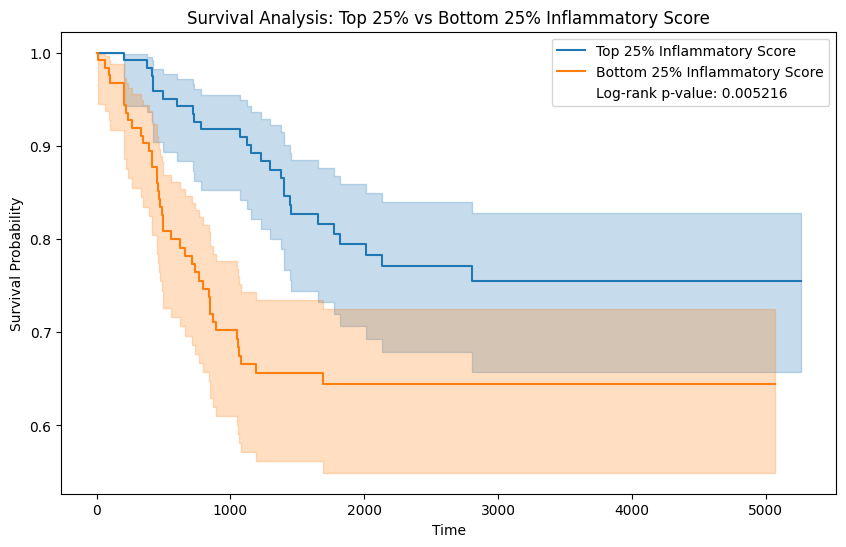

In [36]:
# Stratify samples into top 25% and bottom 25% based on inflammatory_score
top_25 = data[data['inflammatory_score'] >= data['inflammatory_score'].quantile(0.75)]
bottom_25 = data[data['inflammatory_score'] <= data['inflammatory_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% Inflammatory score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Inflammatory Score')
ax = kmf.plot_survival_function()

# Bottom 25% Inflammatory score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Inflammatory Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% Inflammatory Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% Inflammatory Score', f'Bottom 25% Inflammatory Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

### IFN-Alpha

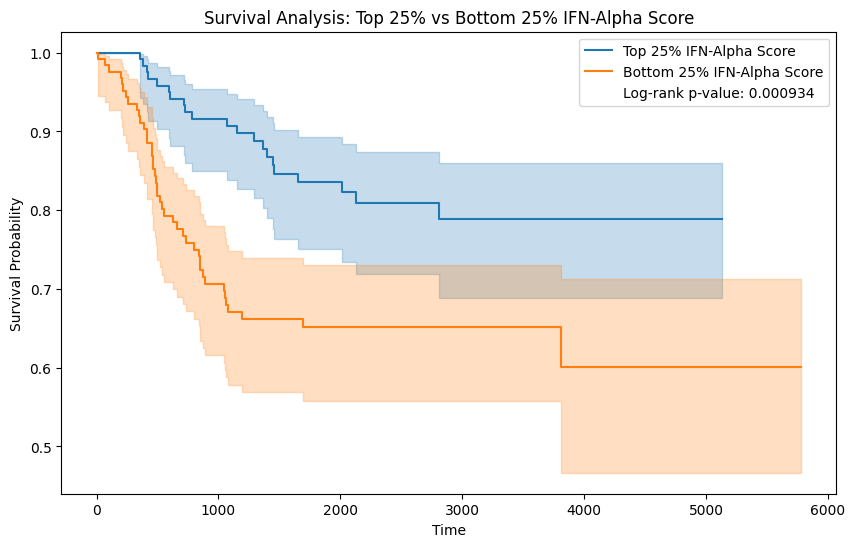

In [37]:
# Stratify samples into top 25% and bottom 25% based on IFN-Alpha score
top_25 = data[data['ifna_score'] >= data['ifna_score'].quantile(0.75)]
bottom_25 = data[data['ifna_score'] <= data['ifna_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IFN-Alpha score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IFN-Alpha Score')
ax = kmf.plot_survival_function()

# Bottom 25% IFN-Alpha score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IFN-Alpha Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IFN-Alpha Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IFN-Alpha Score', f'Bottom 25% IFN-Alpha Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

### IFN-Gamma

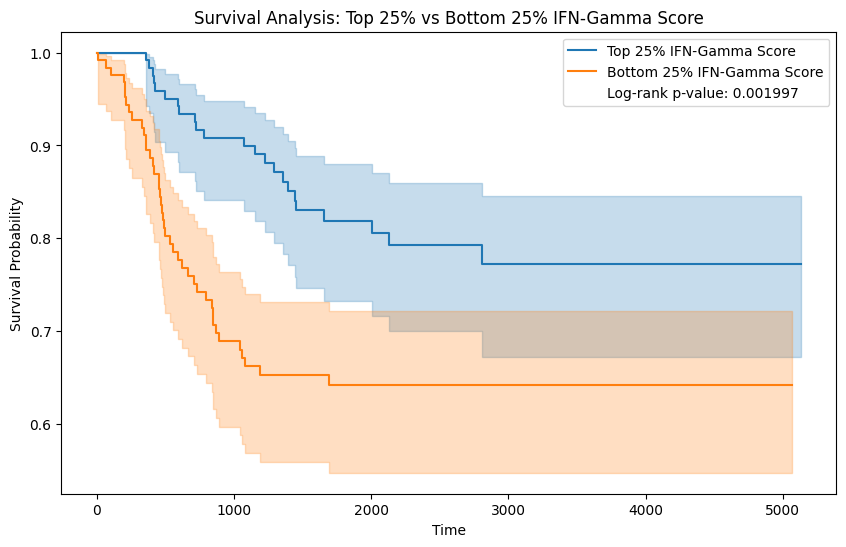

In [38]:
# Stratify samples into top 25% and bottom 25% based on IFN-Gamma score
top_25 = data[data['ifng_score'] >= data['ifng_score'].quantile(0.75)]
bottom_25 = data[data['ifng_score'] <= data['ifng_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IFN-Gamma score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IFN-Gamma Score')
ax = kmf.plot_survival_function()

# Bottom 25% IFN-Gamma score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IFN-Gamma Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IFN-Gamma Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IFN-Gamma Score', f'Bottom 25% IFN-Gamma Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

### Housekeeping

In [39]:
# Extract ACTB expression levels
actb_expression = gene_data.loc[gene_data['Gene'] == 'ACTB', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
actb_expression = actb_expression.reset_index()
actb_expression.columns = ['Sample ID', 'ACTB_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, actb_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['ACTB_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948


In [40]:
actb_expression

,Sample ID,ACTB_expression
0,SEQC_NB001,24.7943
1,SEQC_NB002,25.2958
2,SEQC_NB003,24.5375
3,SEQC_NB004,24.6351
4,SEQC_NB005,24.9948
...,...,...
493,SEQC_NB494,25.4461
494,SEQC_NB495,25.1602
495,SEQC_NB496,25.1211
496,SEQC_NB497,24.7802


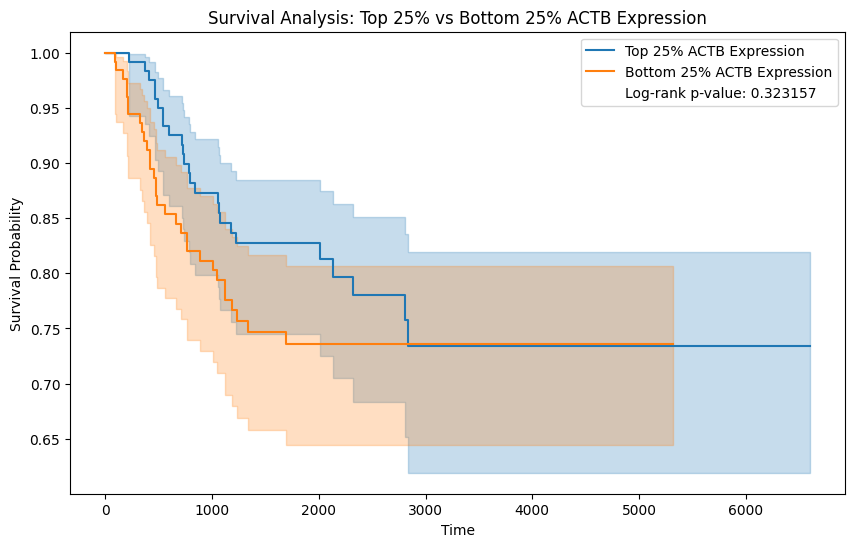

In [41]:
# Stratify samples into top 25% and bottom 25% based on ACTB expression
top_25 = data[data['ACTB_expression'] >= data['ACTB_expression'].quantile(0.75)]
bottom_25 = data[data['ACTB_expression'] <= data['ACTB_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% ACTB expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ACTB Expression')
ax = kmf.plot_survival_function()

# Bottom 25% ACTB expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ACTB Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ACTB Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ACTB Expression', f'Bottom 25% ACTB Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

## Continuous Survival Analysis

- **Cox proportional hazards regression model**: The CoxPHFitter from the lifelines package fits a Cox proportional hazards regression model to the data. This model relates the time that passes before an event occurs to the predictor variables, in this case, the continuous TGF-β score.

### TGF-Beta

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -617.62
         time fit was run = 2024-06-05 12:12:04 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
tgfb_score  -1.06       0.35       0.24            -1.53            -0.59                 0.22                 0.55

             cmp to     z      p   -log2(p)
covariate                                  
tgfb_score     0.00 -4.41 <0.005      16.55
---
Concordance = 0.64
Partial AIC = 1237.23
log-likelihood ratio test = 17.94 on 1 df
-log2(p) of ll-ratio test = 15.42

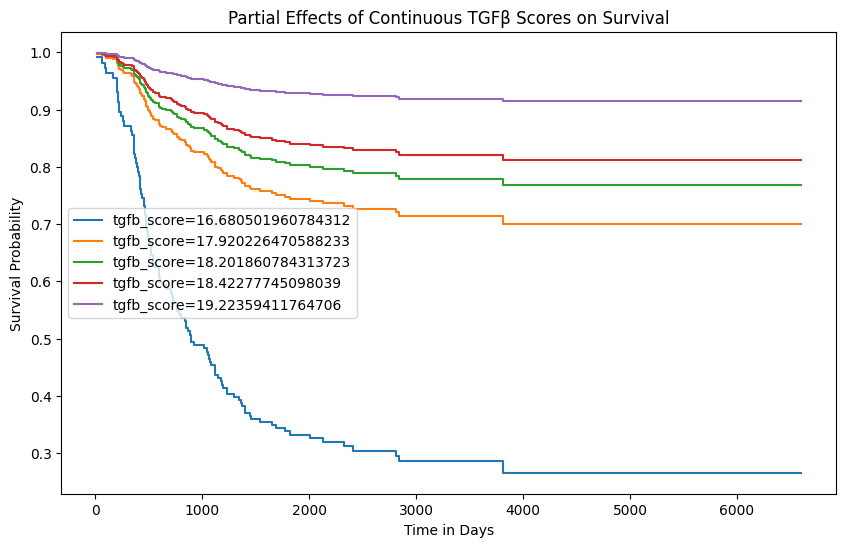

In [44]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'tgfb_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='tgfb_score', values=[cox_data['tgfb_score'].min(), cox_data['tgfb_score'].quantile(0.25), cox_data['tgfb_score'].median(), cox_data['tgfb_score'].quantile(0.75), cox_data['tgfb_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFβ Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IL2 STAT5

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -612.82
         time fit was run = 2024-06-05 12:21:23 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
il2_stat5_score  -0.90       0.41       0.16            -1.22            -0.59                 0.30                 0.56

                  cmp to     z      p   -log2(p)
covariate                                       
il2_stat5_score     0.00 -5.63 <0.005      25.70
---
Concordance = 0.65
Partial AIC = 1227.64
log-likelihood ratio test = 27.53 on 1 df
-log2(p) of ll-ratio test = 22.62

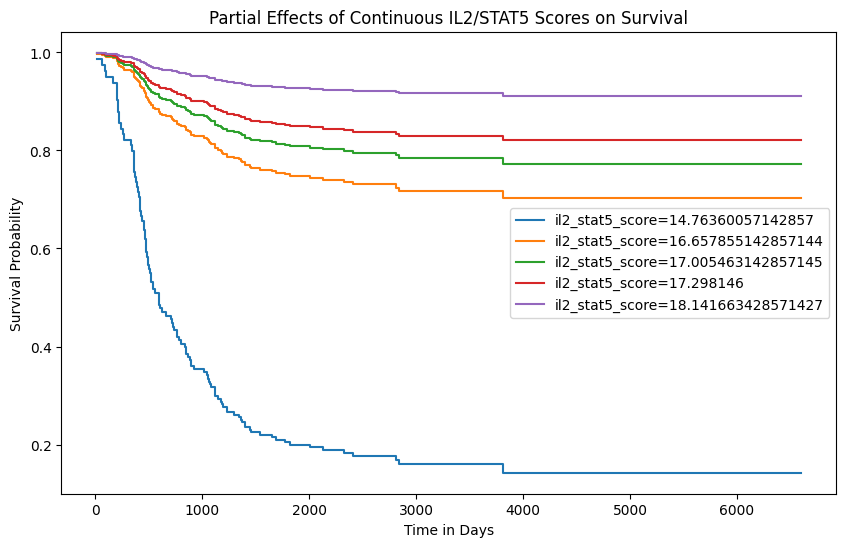

In [45]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'il2_stat5_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IL2/STAT5 scores on survival
cph.plot_partial_effects_on_outcome(covariates='il2_stat5_score', values=[cox_data['il2_stat5_score'].min(), cox_data['il2_stat5_score'].quantile(0.25), cox_data['il2_stat5_score'].median(), cox_data['il2_stat5_score'].quantile(0.75), cox_data['il2_stat5_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IL2/STAT5 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IL6 JAK STAT3

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.27
         time fit was run = 2024-06-05 12:24:05 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
il6_jak_stat3_score  -0.51       0.60       0.11            -0.72            -0.30                 0.49                 0.74

                      cmp to     z      p   -log2(p)
covariate                                           
il6_jak_stat3_score     0.00 -4.81 <0.005      19.34
---
Concordance = 0.62
Partial AIC = 1234.55
log-likelihood ratio test = 20.62 on 1 df
-log2(p) of ll-ratio test = 17.45

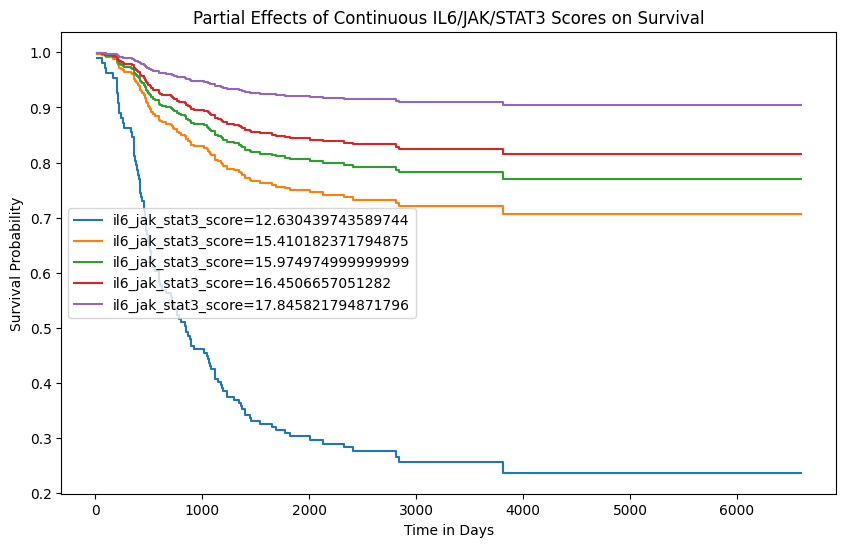

In [46]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'il6_jak_stat3_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IL6/JAK/STAT3 scores on survival
cph.plot_partial_effects_on_outcome(covariates='il6_jak_stat3_score', values=[cox_data['il6_jak_stat3_score'].min(), cox_data['il6_jak_stat3_score'].quantile(0.25), cox_data['il6_jak_stat3_score'].median(), cox_data['il6_jak_stat3_score'].quantile(0.75), cox_data['il6_jak_stat3_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IL6/JAK/STAT3 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### Inflammatory Pathway

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.25
         time fit was run = 2024-06-05 12:26:28 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
inflammatory_score  -0.51       0.60       0.11            -0.72            -0.30                 0.49                 0.74

                     cmp to     z      p   -log2(p)
covariate                                          
inflammatory_score     0.00 -4.83 <0.005      19.46
---
Concordance = 0.62
Partial AIC = 1234.49
log-likelihood ratio test = 20.67 on 1 df
-log2(p) of ll-ratio test = 17.49

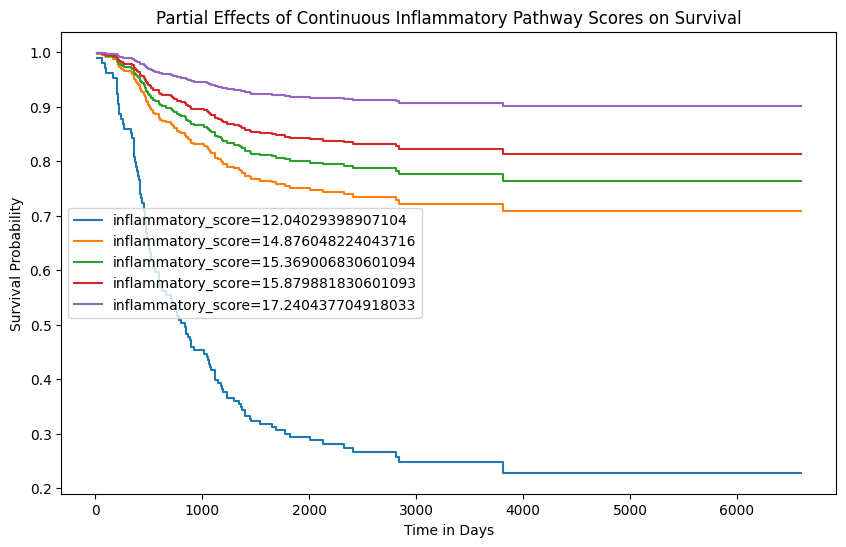

In [47]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'inflammatory_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of Inflammatory Pathway scores on survival
cph.plot_partial_effects_on_outcome(covariates='inflammatory_score', values=[cox_data['inflammatory_score'].min(), cox_data['inflammatory_score'].quantile(0.25), cox_data['inflammatory_score'].median(), cox_data['inflammatory_score'].quantile(0.75), cox_data['inflammatory_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous Inflammatory Pathway Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IFN-Alpha

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -618.26
         time fit was run = 2024-06-05 12:27:51 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
ifna_score  -0.55       0.58       0.14            -0.82            -0.29                 0.44                 0.75

             cmp to     z      p   -log2(p)
covariate                                  
ifna_score     0.00 -4.08 <0.005      14.43
---
Concordance = 0.62
Partial AIC = 1238.53
log-likelihood ratio test = 16.64 on 1 df
-log2(p) of ll-ratio test = 14.43

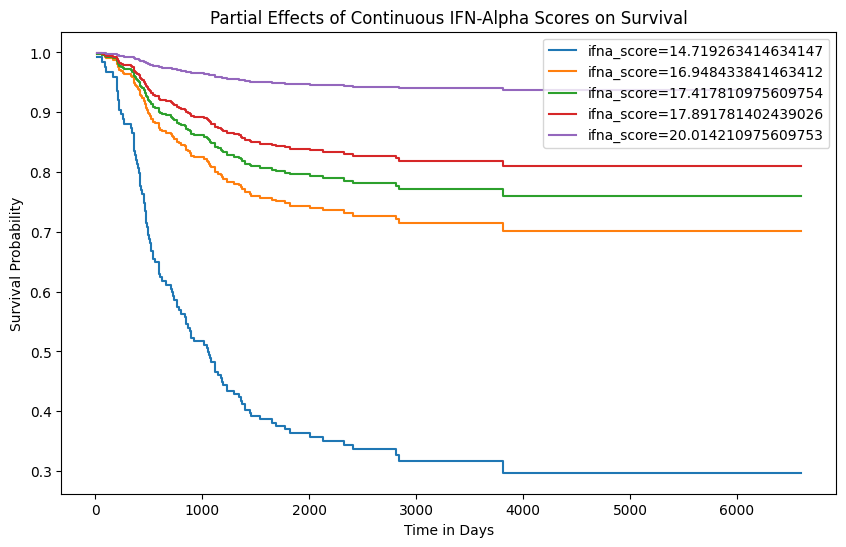

In [48]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ifna_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IFN-a scores on survival
cph.plot_partial_effects_on_outcome(covariates='ifna_score', values=[cox_data['ifna_score'].min(), cox_data['ifna_score'].quantile(0.25), cox_data['ifna_score'].median(), cox_data['ifna_score'].quantile(0.75), cox_data['ifna_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IFN-Alpha Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IFN-Gamma

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -615.48
         time fit was run = 2024-06-05 12:28:27 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
ifng_score  -0.63       0.53       0.13            -0.89            -0.38                 0.41                 0.69

             cmp to     z      p   -log2(p)
covariate                                  
ifng_score     0.00 -4.81 <0.005      19.36
---
Concordance = 0.63
Partial AIC = 1232.97
log-likelihood ratio test = 22.20 on 1 df
-log2(p) of ll-ratio test = 18.63

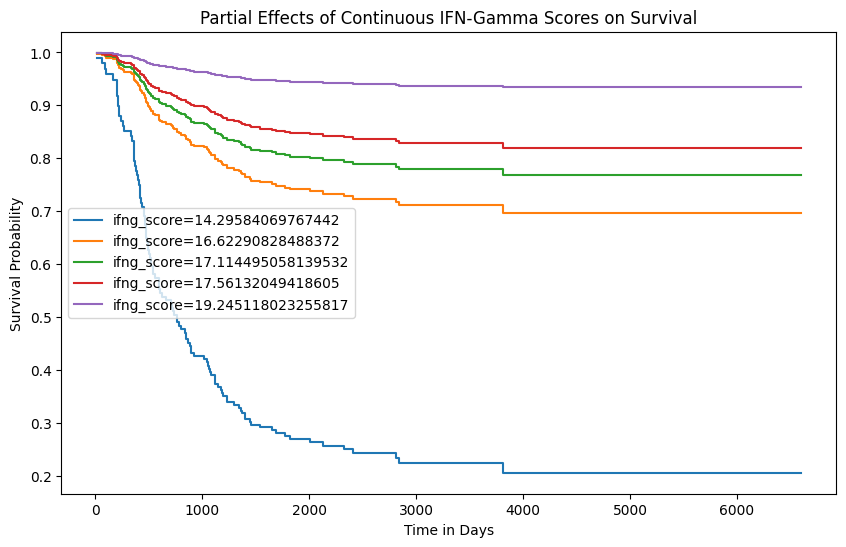

In [49]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ifng_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IFN-Gamma scores on survival
cph.plot_partial_effects_on_outcome(covariates='ifng_score', values=[cox_data['ifng_score'].min(), cox_data['ifng_score'].quantile(0.25), cox_data['ifng_score'].median(), cox_data['ifng_score'].quantile(0.75), cox_data['ifng_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IFN-Gamma Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### Housekeeping

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -625.67
         time fit was run = 2024-06-05 12:31:46 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
ACTB_expression  -0.34       0.71       0.25            -0.82             0.15                 0.44                 1.16

                  cmp to     z    p   -log2(p)
covariate                                     
ACTB_expression     0.00 -1.35 0.18       2.49
---
Concordance = 0.55
Partial AIC = 1253.35
log-likelihood ratio test = 1.82 on 1 df
-log2(p) of ll-ratio test = 2.49

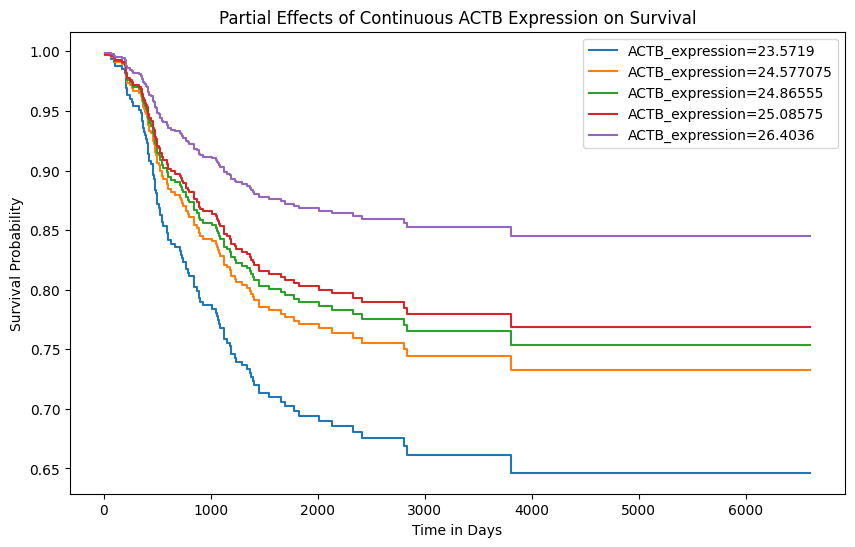

In [50]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ACTB_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='ACTB_expression', values=[cox_data['ACTB_expression'].min(), cox_data['ACTB_expression'].quantile(0.25), cox_data['ACTB_expression'].median(), cox_data['ACTB_expression'].quantile(0.75), cox_data['ACTB_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ACTB Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()